In [1]:
import numpy as np
import os
import glob
import copy
import gmsh
import itertools
from collections import defaultdict
from itertools import chain
from math import atan2
import matplotlib.pyplot as plt

C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# This version of GMSH is equipped with the surface fitting fuctionality
gmsh.__version__

'4.9.0'

---

Next cell imports the numpy arrays representing two surfaces. <br>
It is assumed that model included three layers: basement, reservoir and cap rock.

In [3]:
fil = glob.glob(r"C:\Modelling\GGB_Case\Surfaces\realization_*.npy")
files = sorted(fil, key = lambda name: int(name[-5:-4]))
new_result_list = []
for ind, p in enumerate (files):
    pres = np.load(p).tolist()
    new_result_list.append(pres)

In [4]:
# 11 realizations are considered for Greater Geneva Basin (GGB) model
print (len(new_result_list))

11


In [9]:
extent = np.array([0., 800., 0., 500., -1300., -1000])#dimension of the model: 800, 500 and 300 m in x, y, and z direction
n_iter = len(new_result_list) - 10 # how many realizations are going to be meshed = 11

It is necessary to define that how many points are considered for each layer. <br>
For GGB model, both layers have the same amount of points (1066 points for upper contact and 1066 for the lower). <br>
In total, we are importing 2132 points in each iteration to recreate the topology. We have also 11 realization. <br>
Therefore, a total number of 23452 points are included for all the 11 realization.

In [10]:
length_layers = [[len (new_result_list[0])//2, len (new_result_list[0])//2]] * n_iter
print (length_layers)

[[1066, 1066]]


To rename the generated volumes in GMSH correctly, i.e. _physical properties_, we need to define some points of the <br>
model that we are sure about the geology. These points can be called as representative points (_repre_pts_ in short).<br>
Later on these points will be highlighted in a 3D plot to make them more undrestandable. They will be used as markers <br>
to translate GMSH volumes into geological units. For example, the volume number 1 in mesh will be renamed as _basement_.

In [11]:
repre_pts = [[['400.', '250.', '-1050.', 'cap'],
              ['400.', '250.', '-1150.', 'res'],
              ['400.', '250.', '-1250.', 'basement']]] * n_iter

The figure clearly shows how these representative points can be usefull in mesh generation.<br>
Imagine you have a mesh representing a geological setting with two layers (sand and shale). Only two layers are visualized 
for the sake of simplicity.<br>For later numerical simulations 
you need to define each layer as a physical property in mesh to assign petrophysical properties of each layer correctly.<br>
So, in your mesh you have two volumes representing two formations. Typically physical properties <br>
are defined manually, i.e. volumes are selected and named as their related formations but here it is automated using representative points beacuse we may deal with thousands of realizations for uncertainty analysis. <br>
As the figure shows, the mesh has two volumes differentiated via the color of their nodes. <br>
After importing representative points, GMSH looks for the element that each point belongs to.  
<span style="background-color: #a6a6a6">_gmsh.model.mesh.getElementByCoordinates()_ </span> is the line of code
giving you this possibility.<br>
This line return the element number in GMSH and life is easy after finding this number, 
because <span style="background-color: #a6a6a6">_gmsh.model.mesh.getElement()_ </span>
gives you all the information regarding that element. <br> For example it says which nodes are making the element or to which volume does the element belong.<br> In the following figure elements are shown as cubes just for simplicity.<br>
In practise this method works for tetrahedrons and any other type of the element. Then, by knowing the formation name <br>
in each representative point, physical groups can be defined. As the animation shows, firstly the element encompassing the representative points (shown as stars) is idenfified and then all the other elements belonging to the same volume are conidered to be one physical group/formation.

<h1><center>Physical groups automation</center></h1>
<img src="Visualizations/Mesh_1.jpg" title="Physical groups automation">

<br> <br> The following animation also shows how each element is joining its related physical group. Firstly elements which <br> contain the representative points are detected, and later on all the other elements having the same volume number will <br> be added to the defined physical property.<br>
Let's imagine the lower unit is sand and the upper is shale. The first reperesntative point should contain x, y and z <br> coordinates beside a string which defines a name for it, e.g. _sand layer_: <br>
<span style="background-color: #a6a6a6">[10., 5., 2., 'sand layer']</span>
<br>
Then, GMSH finds the cube firstly highlighted in the lower part of the model and looks for the volume, e.g. 1. Then, all <br> other elelment with the same volume numbers will fall into the _sand layer_ group. <br>
The process also happens in paralel for any other exising formations (volume).

<h1><center>Physical groups automation</center></h1>
<img src="Visualizations/animated_mesh.gif" title="Physical groups automation">

In [12]:
# wells trijectory
wells = [[200.,250.,-1070.], [200.,250.,-1105.], [200.,250.,-1107.], [200.,250.,-1195.], [200.,250.,-1230.],
         [600.,250.,-1070.], [600.,250.,-1105.], [600.,250.,-1107.], [600.,250.,-1195.], [600.,250.,-1230.]]
wel_iter = np.split (np.tile(wells, (n_iter, 1)), n_iter)
wells_cord = [i.tolist() for i in wel_iter]
well_points = [[5., 5.]]
well_p_iter = np.split (np.tile(well_points, (n_iter, 1)), n_iter)
well_points = [i.tolist() for i in well_p_iter]
wl_names = ['Warm', 'Cold'] # Again this names will be used to attribute related physical properties to the lines
# representing wells

The next two functions simply allow for sorting the boundary points of each point cloud. <br> It is important in GMSH to connect the points in the right way for making lines out of them. <br> The next figure visualizes the whole point cloud and it's boundary points. The function sorts them in clockwise.<br> GMSH cannot know by itself how to connect the 12 boundary points (P1 to P12). Making this curve loop is the first step for making surface in GMSH.

In [13]:
def argsort(seq):
    '''
    this function sorts the exterior points in a clockwise order
    '''
    return sorted(range(len(seq)), key = seq.__getitem__)
def rotational_sort(list_of_xy_coords, centre_of_rotation_xy_coord, clockwise=True):
    '''
    this function sorts the exterior points in a clockwise order
    '''
    cx,cy = centre_of_rotation_xy_coord
    angles = [atan2(x-cx, y-cy) for x,y in list_of_xy_coords]
    indices = argsort(angles)
    if clockwise:
        return [list_of_xy_coords[i] for i in indices]
    else:
        return [list_of_xy_coords[i] for i in indices[::-1]]

<h1><center>Sorting the boundary points</center></h1>
<img src="Visualizations/Sort.jpg" title="Sorting the boundary points">

The next cell visualizes what has been discussed in this notebook:
1. The point cloud of one layer in a 2D view (x and y)
2. Margin of the point cloud

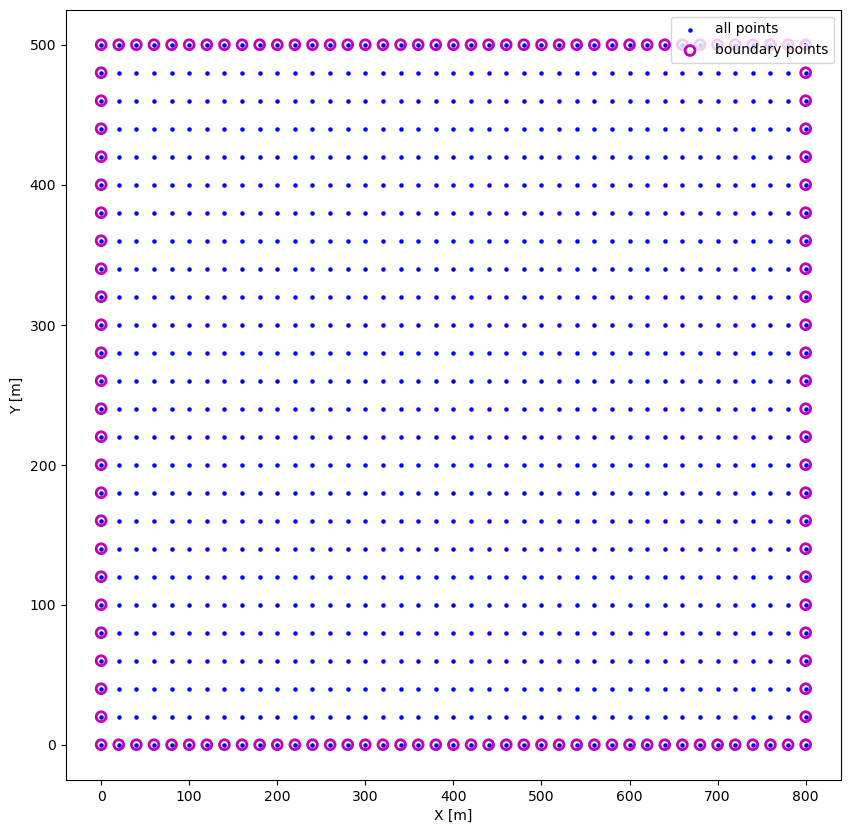

In [14]:
%matplotlib inline

Realization = np.array(new_result_list[1]) # an array of x, y and z of two surface from any realization from 0 to 10
x, y, z = Realization[:,0], Realization[:,1], Realization[:,2] # both the surfaces
x_top, x_bottom = np.split(x, 2)
y_top, y_bottom = np.split(y, 2)
z_top, z_bottom = np.split(z, 2)

# next lines extract the boundary of the point cloud
top, bottom = np.split(Realization, 2)
point_clouds = copy.copy(top)
corn_layers = point_clouds [(point_clouds[:,0] == np.min(point_clouds[:,0])) | # minimum x
               (point_clouds[:,0] == np.max(point_clouds[:,0])) | # maximum x
               (point_clouds[:,1] == np.min(point_clouds[:,1])) | # minimum y
               (point_clouds[:,1] == np.max(point_clouds[:,1]))] # maximum y

corn_layers = corn_layers[np.lexsort((corn_layers[:,1],corn_layers[:,0]))]
pnt = corn_layers[:,0:-1].tolist()
boundary = rotational_sort(pnt, (np.mean(np.array(pnt)[:,0]),np.mean(np.array(pnt)[:,1])),True)
boundary = np.array(boundary)

# and finally the plot
fig, axs = plt.subplots(1, 1, figsize=(10.,10.))
axs.scatter(x_top, y_top, c = 'b', s = 5, label='all points')
axs.scatter(boundary[:,0], boundary[:,1], edgecolors='m', s = 50, facecolor='None', linewidths=2, label='boundary points')
axs.set_ylabel('Y [m]')
axs.set_xlabel('X [m]')
axs.legend()
plt.show()

And a 3D plot to visualize surfaces of iterations, representative points

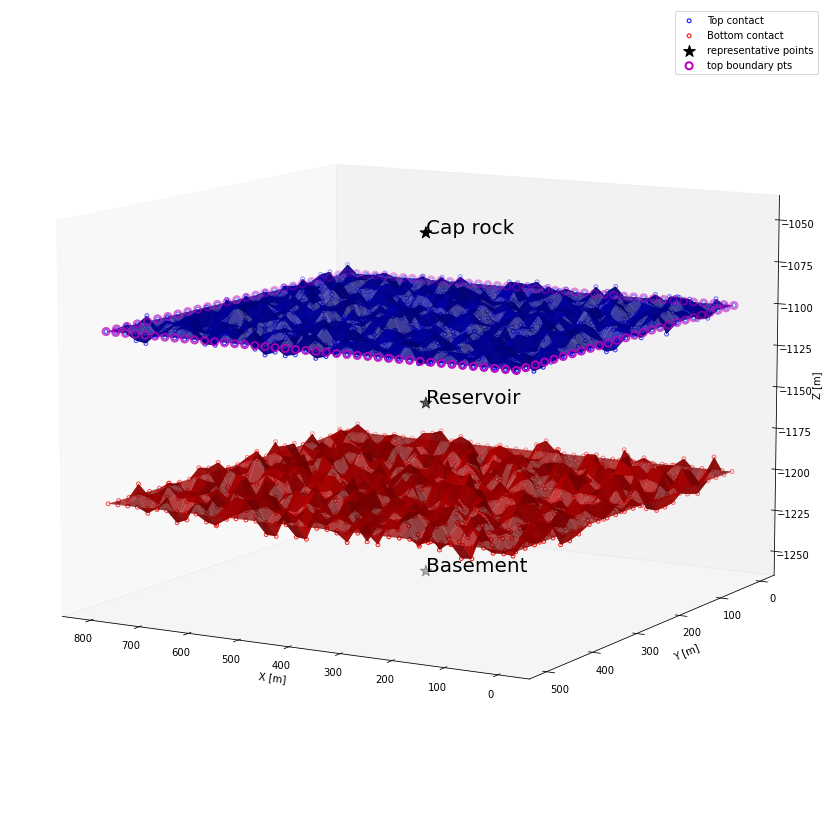

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot (111, projection="3d")
ax.scatter3D(x_top, y_top, z_top, color='b', s=15, label='Top contact', facecolor='None', linewidths=1)
ax.scatter3D(x_bottom, y_bottom, z_bottom, color='r', s=15, label='Bottom contact', facecolor='None', linewidths=1)

# the surface plot
nx, ny = (41, 26) # this defined the number of grid points in x and y directions
ax.plot_surface(x_top.reshape(-1,ny), y_top.reshape(nx,-1), z_top.reshape(nx,-1), color='b', alpha=0.75)
ax.plot_surface(x_bottom.reshape(-1,ny), y_bottom.reshape(nx,-1), z_bottom.reshape(nx,-1), color='r', alpha=0.75)

# representative points
reps = np.array(repre_pts[0])[:,:-1].astype('float')
ax.scatter3D(reps[:,0], reps[:,1], reps[:,2], color='k', s=150, marker = '*', label='representative points')
ax.text(reps[0,0], reps[0,1], reps[0,2], 'Cap rock', fontsize=20)
ax.text(reps[1,0], reps[1,1], reps[1,2], 'Reservoir', fontsize=20)
ax.text(reps[2,0], reps[2,1], reps[2,2], 'Basement', fontsize=20)

# boundary plot
ax.scatter3D(corn_layers[:,0], corn_layers[:,1], corn_layers[:,2], 
             edgecolors='m', s=50, facecolor='None', linewidths=2, label='top boundary pts')
ax.set_zlabel('Z [m]')
ax.set_ylabel('Y [m]')
ax.set_xlabel('X [m]')
plt.legend()
ax.grid(None)
ax.view_init(elev=10., azim=120)
plt.show()

The following cell firstly extracts the _z values_ from the middle of the model and then plots this trace.<br>
It is assumed that we are sure about four depths in the model:
1. Injection well-top of the reservoir contact
2. Injection well-bottom of the reservoir contact
3. Production well-top of the reservoir contact
4. Production well-bottom of the reservoir contact

Therefore, all the iterations converge to the same depths in these four points.

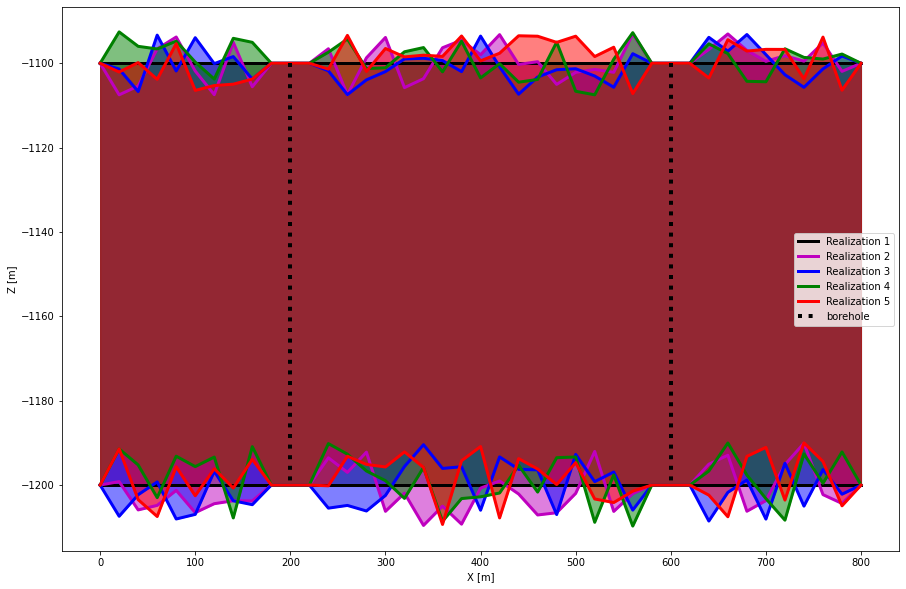

In [12]:
%matplotlib inline
middle_traces = np.array(new_result_list).reshape(-1,3)[13:-12:26]
mid_tr = np.split (middle_traces, n_iter)
c = ['k', 'm', 'b', 'g', 'r', 'purple', 'orange', 'lime', 'c', 'olive', 'brown']
fig, axs = plt.subplots(1, 1, figsize=(15.,10.))
for ind, trace in enumerate (mid_tr[0:5]):
    axs.plot(trace[:41,0], trace[:41,2], lw = 3, c = c[ind], label=f'Realization {ind + 1}')
    axs.plot(trace[41:,0], trace[41:,2], lw = 3, c = c[ind])
    axs.fill_between(trace[:41,0], trace[:41,2], trace[41:,2], color=c[ind], alpha=0.5)
axs.plot([200, 200], [-1100, -1200], lw = 4, ls = ':', c='k', label = 'borehole')
axs.plot([600, 600], [-1100, -1200], lw = 4, ls = ':', c='k')
axs.legend(ncol=1)
axs.set_xlabel('X [m]')
axs.set_ylabel('Z [m]')
plt.show()

The next cell shows a schematic view of the surface fitting functionality of GMSH:
1. Firstly, boundary points are defined, sorted and their lines are created to make a curve loop. This boundary is shown as a dashed line.
2. Surface will be generated by the curve loop that respects the points existing in the middle of the point could (visualized with orange circle). This line of code allows for doing such:
<span style="background-color: #a6a6a6"> _gmsh.model.occ.addSurfaceFilling()_</span>. Tag number of the orange points should be fed into this function as a list. Then, generated surface will be forced to pass through them.

<h1><center>Surface_fit</center></h1>
<img src="Visualizations/Surface_fitting.gif" title="Surface_fit">

The mesh generation cell is a big one *but* after running this cell, you will have 11 mesh files :-) <br>
It is highly recommended to go through available [tutorials on Python API of GMSH](https://gitlab.onelab.info/gmsh/gmsh/-/tree/master/tutorials/python) to familiarize yourself with available options in python API of GMSH. <br>
Some very important GMSH terminologies that are used in the next cell are:
1. Tag number: index of any type of elelemt, e.g. point number 1, 2 and so on.
2. Entities: existing elements in your mesh, e.g. triangles, tetrahedrans and so on.
3. _Distance_ and _Treshold_ refinement methods: fully elaborated [here](https://gmsh.info/doc/texinfo/gmsh.html#Gmsh-mesh-size-fields).
4. Fragment: a super efficient method for spliting your volume and embedding all the entities into their related volumes.
5. Remove: <span style="background-color: #a6a6a6"> _gmsh.model.removeEntities()_</span>: It removes any part of your model based on your choice. You may want to get rid of some points after making your mesh. Like what I do with the point cloud! After making the surfaces, I remove points that has been used to make them.

In [ ]:
def cleanup_and_mesh(entities_to_preserve):
    # remove all embedded constraints, i.e. the entities that are not on the
    # boundary of others
    entities = gmsh.model.getEntities()
    for e in entities:
        emb = gmsh.model.mesh.getEmbedded(e[0], e[1])
        gmsh.model.mesh.removeEmbedded([e])
        for p in entities_to_preserve:
            if p in emb:
                gmsh.model.mesh.embed(p[0], [p[1]], e[0], e[1])
                
    # remove all surfaces, curves and points that are not connected to any
    # higher-dimensional entities
    gmsh.model.removeEntities(gmsh.model.getEntities(2), True)
    cc = gmsh.model.getEntities(1)
    for c in curves_to_preserve_f:
        cc.remove(c)
    gmsh.model.removeEntities(cc, True)
    gmsh.model.removeEntities(gmsh.model.getEntities(0))
    
    # get all surfaces that are not of type "Plane", i.e. all surfaces except the
    # box
    surfaces = [s[1] for s in gmsh.model.getEntities(2) if gmsh.model.getType(s[0], s[1])
                != 'Plane']
    
    # get other surfaces of the box. After introduccing the surface ontacts and cutting one 
    # primary single volum into three ones, tag numbers of the surfaces chnages. Besides tag number,
    # some surfaces also split into 3 ones while for example top and bottom surfaces do not split.
    surface_after = gmsh.model.getEntities(2)
    points = copy.deepcopy(surface_new_tag)
    check_values = [row[-1] for row in surface_after]
    extracted = []
    for sublist in points:
        second_vals = [sec for fir, sec in sublist]
        if all(val in check_values for val in second_vals):
            extracted.append(second_vals)
            
    # create a distance + threshold mesh size field w.r.t. these surfaces. Details of the mesh refinement
    # can be found in https://gmsh.info/doc/texinfo/gmsh.html#Specifying-mesh-element-sizes.
    # Refinement accoring to the top and base of the reservoir:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaces)
    gmsh.model.mesh.field.setNumber(1, "Sampling", 500)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "InField", 1)
    gmsh.model.mesh.field.setNumber(2, "SizeMin", 25)
    gmsh.model.mesh.field.setNumber(2, "SizeMax", 100)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 30)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 150)
    
    # Refinement accoring to the points of the wells:
    gmsh.model.mesh.field.add("Distance", 3)
    gmsh.model.mesh.field.setNumbers(3, "PointsList", [points_to_preserve_f[0][1], points_to_preserve_f[4][1],
                                                       points_to_preserve_f[5][1], points_to_preserve_f[-1][1]])
    gmsh.model.mesh.field.setNumber(3, "Sampling", 100)
    gmsh.model.mesh.field.add("Threshold", 4)
    gmsh.model.mesh.field.setNumber(4, "InField", 3)
    gmsh.model.mesh.field.setNumber(4, "SizeMin", 10)
    gmsh.model.mesh.field.setNumber(4, "SizeMax", 100)
    gmsh.model.mesh.field.setNumber(4, "DistMin", 20)
    gmsh.model.mesh.field.setNumber(4, "DistMax", 200)

    # Refinement accoring to the lines of the wells:
    gmsh.model.mesh.field.add("Distance", 5)
    gmsh.model.mesh.field.setNumbers(5, "CurvesList", np.array(curves_to_preserve[:])[:,1].tolist())
    gmsh.model.mesh.field.setNumber(5, "Sampling", 200)
    gmsh.model.mesh.field.add("Threshold", 6)
    gmsh.model.mesh.field.setNumber(6, "InField", 5)
    gmsh.model.mesh.field.setNumber(6, "SizeMin", 10)
    gmsh.model.mesh.field.setNumber(6, "SizeMax", 100)
    gmsh.model.mesh.field.setNumber(6, "DistMin", 20)
    gmsh.model.mesh.field.setNumber(6, "DistMax", 500)
    
    # A constant refinement for the reservoir:
    gmsh.model.mesh.field.add("Constant", 7)
    gmsh.model.mesh.field.setNumber(7, "VIn", 30.)
    gmsh.model.mesh.field.setNumber(7, "VOut", 100)
    gmsh.model.mesh.field.setNumbers(7, "VolumesList", [2])
    
    gmsh.model.mesh.field.add("Min", 8)
    gmsh.model.mesh.field.setNumbers(8, "FieldsList", [2, 4, 6, 7])
    gmsh.model.mesh.field.setAsBackgroundMesh(8)
    gmsh.option.setNumber("Mesh.MeshSizeMax", 100)
    
    # don't extend mesh sizes from boundaries and use new 3D algo
    gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
    gmsh.option.setNumber("Mesh.Algorithm3D", 10)
    gmsh.model.mesh.generate(3)
    
    # using representative points to create physical volumes
    rep = [list(x) for _,x in itertools.groupby(rep_pnt,lambda x:x[3])]
    vol_num = np.arange(1, 1 + len(rep))
    for ind, surfaces in enumerate (rep):
        tags = []
        for sects in surfaces:
            eleTag = gmsh.model.mesh.getElementByCoordinates(float (sects[0]), float (sects[1]), float (sects[2]))[0]
            eleType, eleNodes, entDim, entTag = gmsh.model.mesh.getElement(eleTag)
            tags.append(entTag)
        gmsh.model.addPhysicalGroup(3, tags, vol_num[ind])
        gmsh.model.setPhysicalName(3, vol_num[ind], sects[-1])
        
    # adding wells as physical lines
    for lines, well_name in zip (well_num, wl_names):
        l1 = gmsh.model.addPhysicalGroup(1, lines.tolist())
        gmsh.model.setPhysicalName(1, l1, well_name)           
    around_box = ['in', 'out', 'front', 'back', 'bottom', 'top']       
    for tag_nu, name in zip (extracted[:6], around_box):
        ps1 = gmsh.model.addPhysicalGroup(2, tag_nu)
        gmsh.model.setPhysicalName(2, ps1, name)
        
    # adding points as physical points
    inj_prod = ['Hot_point', 'Cold_point']
    inj_prod_t = [points_to_preserve_f[2][1], points_to_preserve_f[7][1]]
    for t, po_n in zip (inj_prod_t, inj_prod):
        p1 = gmsh.model.addPhysicalGroup(0, [t])
        gmsh.model.setPhysicalName(0, p1, po_n)
        
        # Witing the mesh
        gmsh.write("Meshes/GGB_" + str(kk) + ".msh")
#     gmsh.fltk.run()
gmsh.initialize()

# the next parameters are related to the surface generation of the GMSH
degree = 3
numPointsOnCurves = 10
numIter = 10
anisotropic = False
tol2d = 0.00001
tol3d = .1
tolAng = 1
tolCurv = 1
maxDegree = 3
maxSegments = 350

# preparing the data of point cloud, representative points and well trijectory and feeding them into  a for loop
sets = zip(new_result_list, repre_pts, wells_cord, well_points)
for kk, (vertices, rep_pnt, well_cord, well_p) in enumerate(sets):
    ar = np.array(vertices)
    l_tags = []
    gmsh.model.occ.addBox(min(ar[:,0]), min(ar[:,1]), extent[-1],
                          max(ar[:,0]) - min(ar[:,0]), max(ar[:,1]) - min(ar[:,1]), extent[-2] - extent[-1])
    
    spl_num = np.cumsum(length_layers[kk]).tolist()[:-1] # each layer is separated
    spl_num = [int (i) for i in spl_num]
    sep_ar = np.split(ar,spl_num)
    
    # A surfaces must be generated for each each layer is separated
    for ind, point_clouds in enumerate (sep_ar):
        point_clouds = point_clouds[np.lexsort((point_clouds[:,1],point_clouds[:,0]))]
        i_l = point_clouds.tolist()
        for [x, y, z] in i_l:
            gmsh.model.occ.addPoint(x, y, z)
        corn_layers = point_clouds [(point_clouds[:,0] == np.min(point_clouds[:,0])) | 
                       (point_clouds[:,0] == np.max(point_clouds[:,0])) |
                       (point_clouds[:,1] == np.min(point_clouds[:,1])) |
                       (point_clouds[:,1] == np.max(point_clouds[:,1]))]
        corn_layers = corn_layers[np.lexsort((corn_layers[:,1],corn_layers[:,0]))] # boundary points are found
        pnt = corn_layers[:,0:-1].tolist()
        arround_pts = rotational_sort(pnt, (np.mean(np.array(pnt)[:,0]),np.mean(np.array(pnt)[:,1])),True)
        arround_pts = np.array(arround_pts) # boundary points are sorted
        tags = np.where((point_clouds[:,:-1] == np.array(arround_pts)[:,None]).all(-1))[1] + 1
        l_tags.append(len(tags))
        start_point = int (8 + np.sum(length_layers[kk][0:ind]))
        start_line = int (13 + np.sum(l_tags[0:ind]))
        for i in range (len(tags)): # this for loop creates the exterior lines of each cloud
            if i != len(tags)-1:
                gmsh.model.occ.addSpline([tags[i] + start_point,tags[i+1] + start_point])
            else:
                gmsh.model.occ.addSpline([tags[i] + start_point,tags[0] + start_point])
        
        gmsh.model.occ.addCurveLoop([i for i in range (start_line, start_line + len(tags))], start_line) # A curve loop
                                                                                                    # created lines
        gmsh.model.occ.addSurfaceFilling(start_line, start_line,
                                         [m for m in range (start_point + 1, start_point+np.max(tags))
                                          if m not in tags + start_point],
                                         degree,
                                         numPointsOnCurves,
                                         numIter,
                                         anisotropic,
                                         tol2d,
                                         tol3d,
                                         tolAng,
                                         tolCurv,
                                         maxDegree,
                                         maxSegments) # create surface by connecting exterior lines
                                                      # and that fits to the point cloud
    gmsh.model.occ.synchronize()
    gmsh.option.setNumber('Geometry.ToleranceBoolean', 0.01)

    in_surf = gmsh.model.occ.getEntities(2) # finds the tag number of created surfaces

    # preparing the coordinates of well trijectories to be added as points and
    # later be coonected to create lines
    tag_well = np.arange(10000, 10000 + len(np.array(well_cord)))
    well_p = np.array(well_p[0]).astype('int')
    tag_well_po = np.split (tag_well, np.cumsum(well_p)[:-1])
    well_po = np.split (np.array(well_cord), np.cumsum(well_p)[:-1]) 
    
    for cord, tag_nu in zip (well_po, tag_well_po):
        for [x, y, z], num in zip (cord,tag_nu):
            gmsh.model.occ.addPoint(x, y, z, tag=num) # points representing the well trijectory added
            
    well_l = well_p - 1        
    tag_w_l = np.arange(5000, 5000 + np.sum(well_l))
    wl = [i.tolist() for i in tag_w_l]
    tag_well_l=np.split (tag_w_l, np.cumsum(well_l)[:-1])

    for po, tag_num in zip (tag_well_po, tag_well_l):
        for i in range (len(po)-1):
            gmsh.model.occ.addLine (po[i], po[int(i+1)], tag = tag_num[i]) # lines connecting the
                                                                  # points that represent the well trijectory added
            
    in_wells = [(1, i) for i in tag_w_l]
    out_all = gmsh.model.occ.fragment(in_surf + in_wells, gmsh.model.occ.getEntities(3))#gives the entities of the model
    out = out_all[1]
    surface_new_tag = out[0:len(in_surf)]
    c = out[len(in_surf):len(in_surf + in_wells)]
    curves_to_preserve = [item for sublist in c for item in sublist]           
    gmsh.model.occ.synchronize()
    points_to_preserve = gmsh.model.getBoundary(curves_to_preserve, combined=False) # which points to keep
                                                       # his method defines the Tag number of two points making a line
    
    # ext lines of code prepare the correct bunch of lines and poits for defininf physcal groups like
    # well, injection and production points and so on
    line_sp = np.array([])
    for i in range (len(points_to_preserve)-1):
        if i%2 != 0:
            if points_to_preserve[i][1] != points_to_preserve[i+1][1]:
                brk = int ((i+1)/2)
                line_sp = np.append(line_sp, brk)
                
    sp_well = np.split(np.array(curves_to_preserve)[:,1], line_sp.astype('int'))
    existing_pos = [x for x in points_to_preserve if points_to_preserve.count(x) >= 2]
    points_to_preserve_f = list(dict.fromkeys(existing_pos))
    
    w1 = np.array (curves_to_preserve[2:4])[:,1]
    w2 = np.array (curves_to_preserve[-4:-2])[:,1] 
    curves_to_preserve_f = curves_to_preserve[2:4]
    mid_curve = curves_to_preserve[8:-2]
    curves_to_preserve_f.extend(mid_curve)
    well_num = np.hstack([w1, w2]).reshape(-1,2)
    
    # The next function allows for mesh generation, refinement an so on
    cleanup_and_mesh(curves_to_preserve_f + points_to_preserve_f)
    gmsh.clear()
    
gmsh.finalize()